In [1]:
%load_ext autoreload

In [3]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp
import numpy as np
import uncertainties as unc

from sys import path
path.append('../')
path.append('../pylib/')
path.append('../../../seaquest-distribution/seaquest_scripts/pylib/')
from emc import *

%autoreload 2
%aimport emc

ImportError: dlopen(/Users/dannowitz/.python-eggs/MySQL_python-1.2.5-py2.7-macosx-10.5-x86_64.egg-tmp/_mysql.so, 2): Library not loaded: /sw/lib/mysql/libmysqlclient_r.15.dylib
  Referenced from: /Users/dannowitz/.python-eggs/MySQL_python-1.2.5-py2.7-macosx-10.5-x86_64.egg-tmp/_mysql.so
  Reason: image not found

### Objectives
1. Create analysis schema and table
2. Get dimuons and spill (proton) data that satisfies specified criteria
3. Specify $x_2$ bin edges and roadset run ranges
4. Calculate EMC ratio for each run range
4. Combine EMC ratio values into a single weighted sum
5. Plot values over E-772 data

Note: set preferences in *emc.cfg* first!

In [3]:
server = 'e906-db3.fnal.gov'
analysis_schema = 'user_dannowitz_analysis_feb2016'
analysis_table = 'kDimuon'
merged_schema_list = ['merged_roadset57_R005_V001',
                      'merged_roadset59_R005_V001',
                      'merged_roadset62_R005_V001',
                      'merged_roadset67_R005_V001']
# If fresh start == True, re-apply all cuts (takes ~10min)
fresh_start = False
#fresh_start = True

In [4]:
# Get valid target dimuons
dimuon_df = get_dimuon_df(server=server, 
                          analysis_schema=analysis_schema, 
                          source_schema_list=merged_schema_list,
                          analysis_table=analysis_table,
                          fresh_start=fresh_start)                                          

In [19]:
dimuon_df['pT'] = np.sqrt(np.square(dimuon_df.dpx)+np.square(dimuon_df.dpy))

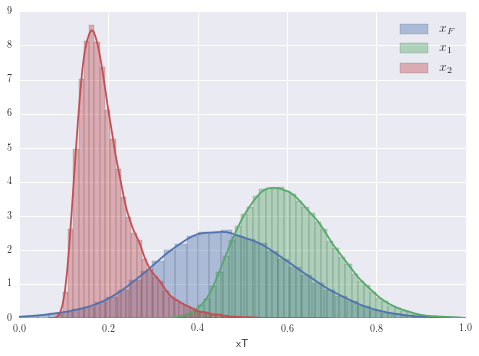

In [17]:
import seaborn as sns
sns.distplot(dimuon_df.xF, label=r'$x_F$', hist_kws={'alpha' : 0.4})
sns.distplot(dimuon_df.xB, label=r'$x_1$', hist_kws={'alpha' : 0.4})
sns.distplot(dimuon_df.xT, label=r'$x_2$', hist_kws={'alpha' : 0.4})
plt.xlim([0,1.0])
plt.legend(fontsize=20)


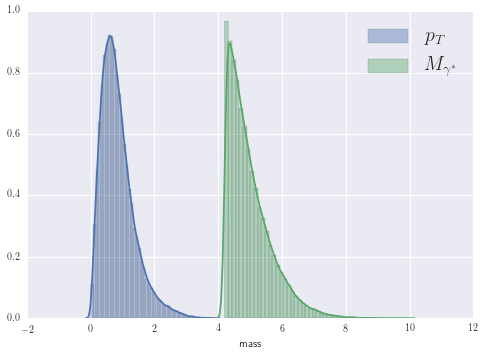

In [21]:
sns.distplot(dimuon_df.pT, label=r'$p_T$', hist_kws={'alpha' : 0.4})
sns.distplot(dimuon_df.mass, label=r'$M_{\gamma^*}$', hist_kws={'alpha' : 0.4})
#plt.xlim([0,1.0])
plt.legend(fontsize=20)

In [11]:
dimuon_df[['dimuonID', 'target', 'Intensity_p']].head()

,dimuonID,target,Intensity_p
0,1642,LD2,9027.40
1,2119,C,26619.80
2,2360,W,28453.10
3,2389,W,33846.90
4,3876,LH2,8410.12


In [12]:
dimuon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82290 entries, 0 to 82289
Data columns (total 39 columns):
dimuonID           82290 non-null int64
runID              82290 non-null int64
spillID            82290 non-null int64
eventID            82290 non-null int64
targetPos          82290 non-null int64
posTrackID         82290 non-null int64
negTrackID         82290 non-null int64
dx                 82290 non-null float64
dy                 82290 non-null float64
dz                 82290 non-null float64
dpx                82290 non-null float64
dpy                82290 non-null float64
dpz                82290 non-null float64
mass               82290 non-null float64
xF                 82290 non-null float64
xB                 82290 non-null float64
xT                 82290 non-null float64
costh              82290 non-null float64
phi                82290 non-null float64
trackSeparation    82290 non-null float64
chisq_dimuon       82290 non-null float64
px1                8229

In [7]:
# Get spill data from specified spills
spill_df = get_spill_df(server=server,
                        analysis_schema=analysis_schema,
                        merged_schema_list=merged_schema_list)

In [10]:
# Write dimuons and spill data to file
dimuon_df.to_csv('dimuon_57_59_62_67.tsv', sep='\t')
spill_df.to_csv('spill_57_59_62_67.tsv', sep='\t')

In [9]:
# Read dimuons and spill data from file
dimuon_df = pd.read_csv('dimuon_57_59_62_67.tsv',
                        sep='\t',
                        index_col='Unnamed: 0')
spill_df = pd.read_csv('spill_57_59_62_67.tsv',
                        sep='\t',
                        index_col='Unnamed: 0')

In [13]:
# Establish run ranges and x_2 bin edges 
run_ranges = [(8912, 10420), (11075, 12438), (12525, 15789)]
bin_edges = [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53]

In [14]:
emc_df, means_list, avg_means_df = emc_analysis(dimuon_df, spill_df, run_ranges,
                                                bin_edges, qie_correction=False)
#emc_df_q, means_list_q, avg_means_df_q = emc_analysis(dimuon_df, spill_df, run_ranges,
#                                                      bin_edges, qie_correction=True)

In [12]:
reload(emc)

<module 'emc' from '../emc.pyc'>

In [8]:
dimuon_df.columns

Index([u'dimuonID', u'runID', u'spillID', u'eventID', u'targetPos',
       u'posTrackID', u'negTrackID', u'dx', u'dy', u'dz', u'dpx', u'dpy',
       u'dpz', u'mass', u'xF', u'xB', u'xT', u'costh', u'phi',
       u'trackSeparation', u'chisq_dimuon', u'px1', u'py1', u'pz1', u'px2',
       u'py2', u'pz2', u'isValid', u'isTarget', u'isDump', u'QIESum',
       u'Intensity_p', u'weight', u'dpt', u'pt1', u'pt2', u'target',
       u'roadset', u'weight_sq'],
      dtype='object')

In [11]:
emc_df

,xT,D/H,C/D,Fe/D,W/D,C/H,Fe/H,W/H,Fe/C,W/C,W/D(iso),W/C(iso),Fe/D(iso),Fe/C(iso)
"(0.08, 0.14]",0.126+/-0.010,1.22+/-0.04,0.97+/-0.04,0.974+/-0.033,0.897+/-0.029,1.17+/-0.05,1.19+/-0.05,1.10+/-0.04,0.97+/-0.04,0.89+/-0.04,0.865+/-0.029,0.855+/-0.035,0.961+/-0.033,0.95+/-0.04
"(0.14, 0.16]",0.150+/-0.006,1.151+/-0.035,1.05+/-0.04,1.044+/-0.035,0.988+/-0.031,1.22+/-0.05,1.20+/-0.05,1.14+/-0.04,0.98+/-0.04,0.94+/-0.04,0.963+/-0.031,0.915+/-0.035,1.034+/-0.034,0.98+/-0.04
"(0.16, 0.18]",0.170+/-0.006,1.19+/-0.04,1.03+/-0.04,1.018+/-0.033,1.033+/-0.031,1.23+/-0.05,1.21+/-0.05,1.24+/-0.05,0.98+/-0.04,0.99+/-0.04,1.000+/-0.030,0.961+/-0.035,1.007+/-0.033,0.97+/-0.04
"(0.18, 0.21]",0.194+/-0.009,1.195+/-0.033,1.067+/-0.034,1.077+/-0.031,1.008+/-0.028,1.27+/-0.05,1.28+/-0.04,1.21+/-0.04,1.013+/-0.035,0.941+/-0.031,0.976+/-0.027,0.911+/-0.031,1.064+/-0.031,1.002+/-0.034
"(0.21, 0.25]",0.227+/-0.011,1.17+/-0.04,1.09+/-0.04,1.09+/-0.04,1.072+/-0.033,1.28+/-0.05,1.27+/-0.05,1.26+/-0.05,0.99+/-0.04,0.98+/-0.04,1.041+/-0.033,0.95+/-0.04,1.07+/-0.04,0.98+/-0.04
"(0.25, 0.31]",0.275+/-0.017,1.10+/-0.04,1.07+/-0.04,1.02+/-0.04,0.96+/-0.04,1.22+/-0.06,1.12+/-0.05,1.06+/-0.05,0.94+/-0.04,0.89+/-0.04,0.945+/-0.035,0.87+/-0.04,1.01+/-0.04,0.94+/-0.04
"(0.31, 0.53]",0.36+/-0.05,1.17+/-0.06,1.04+/-0.06,1.03+/-0.06,1.08+/-0.05,1.22+/-0.09,1.20+/-0.08,1.27+/-0.08,0.96+/-0.06,1.03+/-0.06,1.05+/-0.05,1.00+/-0.06,1.02+/-0.06,0.95+/-0.06


In [10]:
means_list[0]

mass                dz      dpz        dpt  \
target xT                                                                
C      (0.08, 0.14]  4.42+/-0.18  (-1.5+/-0.5)e+02  88+/-10  0.8+/-0.5   
       (0.14, 0.16]  4.54+/-0.25  (-1.5+/-0.5)e+02   77+/-9  0.8+/-0.5   
       (0.16, 0.18]  4.72+/-0.31  (-1.5+/-0.4)e+02  73+/-10  0.8+/-0.5   
       (0.18, 0.21]    4.9+/-0.4  (-1.4+/-0.4)e+02  70+/-10  0.8+/-0.5   
       (0.21, 0.25]    5.3+/-0.4  (-1.5+/-0.4)e+02  69+/-11  1.0+/-0.6   
       (0.25, 0.31]    5.8+/-0.5  (-1.4+/-0.4)e+02  68+/-10  1.0+/-0.6   
       (0.31, 0.53]    6.6+/-0.7  (-1.5+/-0.4)e+02  68+/-11  1.0+/-0.7   
Empty  (0.08, 0.14]  4.36+/-0.12  (-1.8+/-0.8)e+02   85+/-8  1.0+/-0.7   
       (0.14, 0.16]  4.50+/-0.19  (-2.0+/-0.5)e+02   76+/-9  0.9+/-0.5   
       (0.16, 0.18]  4.79+/-0.31  (-2.1+/-0.5)e+02   78+/-8  1.1+/-0.8   
       (0.18, 0.21]  4.93+/-0.35  (-1.9+/-0.4)e+02  72+/-10  1.1+/-0.6   
       (0.21, 0.25]    5.4+/-0.4  (-1.7+/-0.5)e+02  68+/-14  0.8+/-0.6   
       (0.25, 0.31]  5.51+/-0.27  (-1.6+/-0.5)e+02   64+/-7  1.2+/-0.7   
       (0.31, 0.53]    6.6+/-0.7  (-1.6+/-0.6)e+02  69+/-10  1.5+/-1.0   
Fe     (0.08, 0.14]  4.39+/-0.17  (-1.4+/-0.5)e+02   87+/-9  0.7+/-0.4   
       (0.14, 0.16]  4.53+/-0.22  (-1.5+/-0.4)e+02   77+/-8  0.8+/-0.5   
       (0.16, 0.18]  4.69+/-0.32  (-1.4+/-0.4)e+02  72+/-10  0.8+/-0.5   
       (0.18, 0.21]    4.9+/-0.4  (-1.4+/-0.4)e+02  70+/-10  0.9+/-0.4   
       (0.21, 0.25]    5.3+/-0.4  (-1.4+/-0.4)e+02  68+/-11  0.9+/-0.5   
       (0.25, 0.31]    5.8+/-0.5  (-1.4+/-0.4)e+02  68+/-11  1.0+/-0.6   
       (0.31, 0.53]    6.3+/-0.6  (-1.5+/-0.4)e+02  63+/-10  1.2+/-0.8   
LD2    (0.08, 0.14]  4.41+/-0.17  (-1.5+/-0.5)e+02   87+/-9  0.7+/-0.4   
       (0.14, 0.16]  4.53+/-0.25  (-1.5+/-0.5)e+02   77+/-9  0.8+/-0.5   
       (0.16, 0.18]  4.70+/-0.31  (-1.4+/-0.4)e+02  73+/-10  0.8+/-0.5   
       (0.18, 0.21]    4.9+/-0.4  (-1.4+/-0.4)e+02  70+/-10  0.8+/-0.5   
       (0.21, 0.25]    5.3+/-0.4  (-1.4+/-0.4)e+02  68+/-10  0.9+/-0.6   
       (0.25, 0.31]    5.7+/-0.5  (-1.4+/-0.4)e+02  66+/-11  1.0+/-0.7   
       (0.31, 0.53]    6.5+/-0.7  (-1.4+/-0.4)e+02  65+/-12  1.1+/-0.8   
LH2    (0.08, 0.14]  4.41+/-0.16  (-1.6+/-0.5)e+02   86+/-9  0.7+/-0.4   
       (0.14, 0.16]  4.55+/-0.27  (-1.5+/-0.5)e+02   78+/-9  0.8+/-0.5   
       (0.16, 0.18]  4.68+/-0.32  (-1.5+/-0.5)e+02  72+/-10  0.8+/-0.5   
       (0.18, 0.21]    4.9+/-0.4  (-1.4+/-0.5)e+02  69+/-11  0.9+/-0.6   
       (0.21, 0.25]    5.3+/-0.4  (-1.4+/-0.4)e+02  69+/-11  1.0+/-0.6   
       (0.25, 0.31]    5.7+/-0.5  (-1.4+/-0.4)e+02  67+/-12  1.1+/-0.7   
       (0.31, 0.53]    6.4+/-0.7  (-1.4+/-0.4)e+02  65+/-12  1.1+/-0.8   
None   (0.08, 0.14]  4.35+/-0.16  (-2.1+/-0.6)e+02  90+/-10  0.9+/-0.5   
       (0.14, 0.16]  4.55+/-0.28  (-1.9+/-0.5)e+02   78+/-9  1.0+/-0.6   
       (0.16, 0.18]  4.63+/-0.20  (-2.0+/-0.5)e+02   74+/-8  1.1+/-0.8   
       (0.18, 0.21]  4.99+/-0.30  (-2.0+/-0.6)e+02   74+/-9  1.2+/-0.6   
       (0.21, 0.25]  5.37+/-0.35  (-1.8+/-0.5)e+02  74+/-10  1.4+/-0.9   
       (0.25, 0.31]  5.36+/-0.16         -184+/-32   69+/-7  2.4+/-0.7   
       (0.31, 0.53]    6.2+/-0.5  (-1.7+/-0.5)e+02  61+/-10  1.4+/-0.9   
W      (0.08, 0.14]  4.38+/-0.18  (-1.5+/-0.4)e+02   86+/-9  0.7+/-0.4   
       (0.14, 0.16]  4.54+/-0.24  (-1.4+/-0.4)e+02   77+/-8  0.7+/-0.4   
       (0.16, 0.18]  4.68+/-0.29  (-1.4+/-0.4)e+02   72+/-9  0.8+/-0.5   
       (0.18, 0.21]    4.9+/-0.4  (-1.4+/-0.4)e+02  70+/-11  0.9+/-0.4   
       (0.21, 0.25]    5.3+/-0.4  (-1.4+/-0.4)e+02  68+/-10  0.9+/-0.5   
       (0.25, 0.31]    5.7+/-0.5  (-1.4+/-0.4)e+02  66+/-11  1.1+/-0.6   
       (0.31, 0.53]    6.4+/-0.6  (-1.4+/-0.4)e+02  65+/-12  1.1+/-0.7   

                         pz1      pz2          pt1          pt2           xF  \
target xT                                                                      
C      (0.08, 0.14]  45+/-12  43+/-11    2.1+/-0.4    2.1+/-0.4  0.67+/-0.10   
       (0.14,

In [14]:
avg_means_df.columns

Index([u'mass', u'dz', u'dpz', u'dpt', u'pz1', u'pz2', u'pt1', u'pt2', u'xF',
       u'xB', u'xT', u'costh', u'phi', u'trackSeparation', u'chisq_dimuon',
       u'QIESum'],
      dtype='object')

In [21]:
print avg_means_df['mass'].ix['LD2']

xT
(0.08, 0.14]    4.41+/-0.10
(0.14, 0.16]    4.54+/-0.14
(0.16, 0.18]    4.70+/-0.18
(0.18, 0.21]    4.91+/-0.21
(0.21, 0.25]    5.28+/-0.24
(0.25, 0.31]    5.75+/-0.28
(0.31, 0.53]      6.5+/-0.4
Name: mass, dtype: object


In [7]:
emc_df_high, means_list, avg_means_df = emc_analysis(
    dimuon_df.query('Intensity_p >= 30000 and Intensity_p < 1000000'),
    spill_df,
    run_ranges,
    bin_edges,
    qie_correction=False)
emc_df_low, means_list, avg_means_df = emc_analysis(
    dimuon_df.query('Intensity_p < 30000 and Intensity_p > 0'),
    spill_df,
    run_ranges,
    bin_edges,
    qie_correction=False)
#emc_df_q, means_list_q, avg_means_df_q = emc_analysis(dimuon_df.query('Intensity_p < 30000'),
#                                                      spill_df,
#                                                      run_ranges,
#                                                      bin_edges,
#                                                      qie_correction=True)

In [ ]:
emc_df57, means_list57, avg_means_df57 = emc_analysis(dimuon_df, spill_df, [(8912, 10420)], bin_edges, qie_correction=False)
emc_df62, means_list62, avg_means_df62 = emc_analysis(dimuon_df, spill_df, [(11075, 12438)], bin_edges, qie_correction=False)
emc_df67, means_list67, avg_means_df67 = emc_analysis(dimuon_df, spill_df, [(12525, 15789)], bin_edges, qie_correction=False)

In [ ]:
emc_df57.head()

In [ ]:
np.set_printoptions(precision=8)
pd.set_option('display.precision',8)
pd.set_option('display.max_colwidth',100)
pd.set_option('display.float_format', '{:.02f}'.format)
avg_means_df57

In [ ]:
print avg_means_df57[["counts", "ncounts"]].groupby(by=None, axis=0, level=0).sum().values

In [ ]:
print emc_df.to_latex()

In [15]:
bin_centers = unp.nominal_values(emc_df['xT'].values)
lower_val = np.subtract(bin_centers,bin_edges[:-1])
upper_val = np.subtract(bin_edges[1:], bin_centers)
asymmetric_bars = [lower_val, upper_val]

In [9]:
emc_df

,xT,D/H,C/D,Fe/D,W/D,C/H,Fe/H,W/H,Fe/C,W/C,W/D(iso),W/C(iso),Fe/D(iso),Fe/C(iso)
"(0.08, 0.14]",0.126+/-0.010,1.22+/-0.04,0.97+/-0.04,0.974+/-0.033,0.897+/-0.029,1.17+/-0.05,1.19+/-0.05,1.10+/-0.04,0.97+/-0.04,0.89+/-0.04,0.865+/-0.029,0.855+/-0.035,0.961+/-0.033,0.95+/-0.04
"(0.14, 0.16]",0.150+/-0.006,1.151+/-0.035,1.05+/-0.04,1.044+/-0.035,0.988+/-0.031,1.22+/-0.05,1.20+/-0.05,1.14+/-0.04,0.98+/-0.04,0.94+/-0.04,0.963+/-0.031,0.915+/-0.035,1.034+/-0.034,0.98+/-0.04
"(0.16, 0.18]",0.170+/-0.006,1.19+/-0.04,1.03+/-0.04,1.018+/-0.033,1.033+/-0.031,1.23+/-0.05,1.21+/-0.05,1.24+/-0.05,0.98+/-0.04,0.99+/-0.04,1.000+/-0.030,0.961+/-0.035,1.007+/-0.033,0.97+/-0.04
"(0.18, 0.21]",0.194+/-0.009,1.195+/-0.033,1.067+/-0.034,1.077+/-0.031,1.008+/-0.028,1.27+/-0.05,1.28+/-0.04,1.21+/-0.04,1.013+/-0.035,0.941+/-0.031,0.976+/-0.027,0.911+/-0.031,1.064+/-0.031,1.002+/-0.034
"(0.21, 0.25]",0.227+/-0.011,1.17+/-0.04,1.09+/-0.04,1.09+/-0.04,1.072+/-0.033,1.28+/-0.05,1.27+/-0.05,1.26+/-0.05,0.99+/-0.04,0.98+/-0.04,1.041+/-0.033,0.95+/-0.04,1.07+/-0.04,0.98+/-0.04
"(0.25, 0.31]",0.275+/-0.017,1.10+/-0.04,1.07+/-0.04,1.02+/-0.04,0.96+/-0.04,1.22+/-0.06,1.12+/-0.05,1.06+/-0.05,0.94+/-0.04,0.89+/-0.04,0.945+/-0.035,0.87+/-0.04,1.01+/-0.04,0.94+/-0.04
"(0.31, 0.53]",0.36+/-0.05,1.17+/-0.06,1.04+/-0.06,1.03+/-0.06,1.08+/-0.05,1.22+/-0.09,1.20+/-0.08,1.27+/-0.08,0.96+/-0.06,1.03+/-0.06,1.05+/-0.05,1.00+/-0.06,1.02+/-0.06,0.95+/-0.06


/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


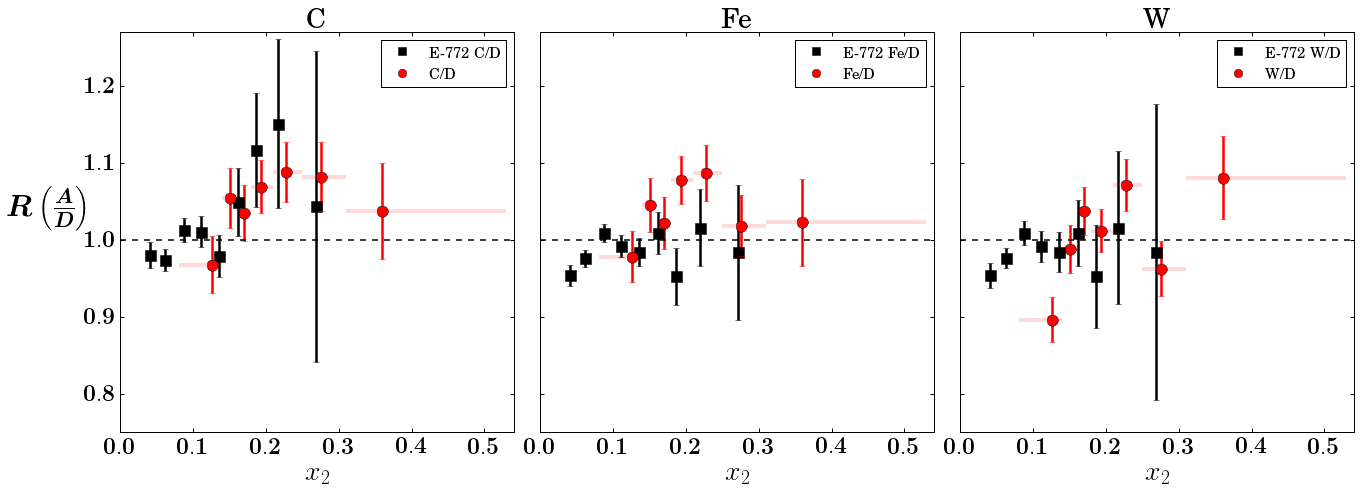

In [19]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D']], ['C/D'],
               [emc_df['Fe/D']], ['Fe/D'],
               [emc_df['W/D']], ['W/D'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df57['C/D'], emc_df62['C/D'], emc_df67['C/D']],
               ['R57 C/D', 'R62 C/D', 'R67 C/D'],
               [emc_df57['Fe/D'], emc_df62['Fe/D'], emc_df67['Fe/D']],
               ['R57 Fe/D', 'R62 Fe/D', 'R67 Fe/D'],
               [emc_df57['W/D'], emc_df62['W/D'], emc_df67['W/D']],
               ['R57 W/D', 'R62 W/D', 'R67 W/D'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D']], ['C/D'],
               [emc_df['Fe/D']], ['Fe/D'],
               [emc_df['W/D']], ['W/D'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D']], ['C/D'],
               [emc_df['Fe/D'], emc_df['Fe/D(iso)']], ['Fe/D', 'Fe/D (iso)'],
               [emc_df['W/D'], emc_df['W/D(iso)']], ['W/D', 'W/D (iso)'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D']], ['C/D'],
               [emc_df['Fe/C'], emc_df['Fe/C(iso)']], ['Fe/C', 'Fe/C (iso)'],
               [emc_df['W/C'], emc_df['W/C(iso)']], ['W/C', 'W/C (iso)'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D']], ['C/D'],
               [emc_df['Fe/D(iso)'], emc_df['Fe/C(iso)']], ['Fe/D (iso)', 'Fe/C (iso)'],
               [emc_df['W/D(iso)'], emc_df['W/C(iso)']], ['W/D (iso)', 'W/C (iso)'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D'], emc_df_q['C/D']], ['C/D', r'C/D ($I_p$)'],
               [emc_df['Fe/D'], emc_df_q['Fe/D']], ['Fe/D', r'Fe/D ($I_p$)'],
               [emc_df['W/D'], emc_df_q['W/D']], ['W/D', r'W/D ($I_p$)'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D'], emc_df_q['C/D']], ['C/D', r'C/D ($I_p$)'],
               [emc_df['Fe/C'], emc_df_q['Fe/C']], ['Fe/C', r'Fe/C ($I_p$)'],
               [emc_df['W/C'], emc_df_q['W/C']], ['W/C', r'W/C ($I_p$)'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D'], emc_df_q['C/D']], ['C/D', r'C/D ($I_p$)'],
               [emc_df['Fe/D(iso)'], emc_df_q['Fe/D(iso)']],
               ['Fe/D (iso)', r'Fe/D (iso, $I_p$)'],
               [emc_df['W/D(iso)'], emc_df_q['W/D(iso)']],
               ['W/D (iso)', r'W/D (iso, $I_p$)'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D'], emc_df_q['C/D']], ['C/D', r'C/D ($I_p$)'],
               [emc_df['Fe/C(iso)'], emc_df_q['Fe/C(iso)']],
               ['Fe/C (iso)', r'Fe/C (iso, $I_p$)'],
               [emc_df['W/C(iso)'], emc_df_q['W/C(iso)']],
               ['W/C (iso)', r'W/C (iso, $I_p$)'])

In [ ]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['D/H'], emc_df_q['D/H']], ['D/H', r'D/H ($I_p$)'],
               [emc_df['Fe/H'], emc_df_q['Fe/H']],
               ['Fe/H', r'Fe/H ($I_p$)'],
               [emc_df['W/H'], emc_df_q['W/H']],
               ['W/H', r'W/H ($I_p$)'],
               lims=(0, 0.54, 0.75, 1.5),
               savefile='H-ratio.png')

In [ ]:
target_df.index.values